Complex Laplacian and its eigenmodes are parameterized by $\alpha$ and $k$.
---

Theory and math behind the eigenmodes:

The simplest possible dynamic behavior of a damped system is the first order differential equation with one term, and it's rate of exponential decay is governed by a rate contant $\beta$:

\begin{equation}
\label{dampedSys}
  \frac{dx_{1}(t)}{dt} = -\beta x_{1}(t)
\end{equation}

Where $x_{1}(t)$ is the average neuronal activation signal between all neurons within a region of interest. Thus we can interpret the above equation as the refractory period after neural discharge. But when viewing the brain as a network of interconnected regions, we want to introduce activities originating from other regions:

\begin{equation}
  \frac{dx_{i}(t)}{dt} = -\beta (x_{i}(t) - \frac{\alpha}{\pmb{deg_i}} \sum_{i,j} c_{i,j} x_{j}(t-\tau^{\nu}_{i,j}))
\end{equation}

The above equation introduces a connectivity $c_{i,j}$ term, which is normalized by a diagonal degree matrix and scaled by a coupling term $\alpha$. $\alpha$ acts as both a coupling constant as well as a parameter to distinguish the rate of diffusion from connected regions from $\beta$. By introducing connectivity, we also have to take into account the distance between each connected regions, therefore the term $\tau^{\nu}_{i,j}$ is introduced as delay, and is computed by dividing fiber tract distance between regions and signal transmission velocity. Now if we transform the above equation into the Fourier domain, we obtain the follow complex expression:

\begin{equation}
\begin{aligned}
    j\omega X(\omega)_{i} = -\beta X(\omega)_{i} + \frac{\alpha}{\pmb{deg_i}} \sum_j c_{i,j} e^{-j\omega \tau^{\nu}_{i,j}} X(\omega)\\
    j\omega \bar{X}(\omega) = -\beta (I - \alpha \Delta^{-\frac{1}{2}} C^{*}(\omega)) \bar{X}(\omega)\\
    j\omega \bar{X}(\omega) = -B\mathcal{L}\bar{X}(\omega)\\
\end{aligned}
\end{equation}

Here, we introduced a complex component to our structural connectivity term as delays become phases in the Fourier domain, specifically, $x(t-\tau^{\nu}_{i,j}) \to e^{-j\omega \tau^{\nu}_{i,j}} X(\omega)$, thus we can define a complex connectivity as a function of angular frequency $\omega$ as $C(\omega) = \frac{1}{\pmb{deg}}C^{*}(\omega)$, where $C^{*}(\omega) = c_{i,j}e^{-j\omega \tau^{\nu}_{i,j}}$. By redefining the connectivity term from above, the complex Laplacian $\mathcal{L}(\omega)$ is then defined as $\mathcal{L}(\omega) = I - \alpha C(\omega)$. Next we decompose the complex Laplacian matrix $\mathcal{L}$ into it's eigen modes and eigen values:

\begin{equation}
    \mathcal{L}(\omega) = \pmb(U)(\omega)\pmb{\Lambda}(\omega)\pmb{U}(\omega)^H
\end{equation}

Where $\pmb{\Lambda}(\omega) = diag([\lambda_1(\omega), ... , \lambda_N(\omega)])$ is a diagonal matrix consisting of the eigen values of the complex Laplacian matrix at angular frequency $\omega$, and $\pmb{U}(\omega)$ are the eigen modes of the complex Laplacian matrix at angular frequency $\omega$. We are going to see how these eigenmodes behave in their parameter space:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# spectrome imports
from spectrome.brain import Brain
from spectrome.utils import functions, path
from spectrome.forward import eigenmode, runforward

In [ ]:
# Some house keeping:
data_dir = "../data"

# Define frequency range of interest
fmin = 2  # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
fvec = np.linspace(fmin, fmax, 40)

# Load Pablo's Yeo 2017 canonical network maps
fc_dk = np.load("../data/com_dk.npy", allow_pickle=True).item()
fc_dk_normalized = pd.read_csv("../data/DK_dictionary_normalized.csv").set_index(
    "Unnamed: 0"
)

# Define variables for analysis:
alpha_vec = np.linspace(
    0.5, 4.5, 17
)  # np.linspace(0.5,5,10) # coupling strength values we are going to explore
k_vec = np.linspace(0, 100, 11)  # wave numbers we are going to explore
num_fc = 7  # 7 canonical networks
num_emode = 86  # number of eigenmodes, we are using 86 region DK atlas

default_k = 20  # default wave number
default_alpha = 0.1  # default alpha

# define list of canonical network names and re-order the dictionary using these names:
fc_names = [
    "Limbic",
    "Default",
    "Visual",
    "Fronto \n parietal",
    "Somato \n motor",
    "Dorsal \n Attention",
    "Ventral \n Attention",
]
fc_dk_normalized = fc_dk_normalized.reindex(
    [
        "Limbic",
        "Default",
        "Visual",
        "Frontoparietal",
        "Somatomotor",
        "Dorsal_Attention",
        "Ventral_Attention",
    ]
).fillna(0)

# turbo color map
turbo = functions.create_turbo_colormap()

#### Explore varying coupling strength while keeping wave number default first

In [ ]:
## Create Brain object from spectrome
alpha_brain = Brain.Brain()
alpha_brain.add_connectome(data_dir)
alpha_brain.reorder_connectome(alpha_brain.connectome, alpha_brain.distance_matrix)
alpha_brain.bi_symmetric_c()
alpha_brain.reduce_extreme_dir()

## Compute correlation values:
alpha_corr = np.zeros((num_emode, num_fc, len(alpha_vec)))
for a_ind in np.arange(0, len(alpha_vec)):
    alpha_brain.decompose_complex_laplacian(alpha=alpha_vec[a_ind], k=default_k)
    alpha_corr[:, :, a_ind] = eigenmode.get_correlation_df(
        alpha_brain.norm_eigenmodes, fc_dk_normalized, method="spearman"
    )

In [ ]:
## set-up some visualization details
dynamic_range = [0.35, 0.65]  # for colormap
# for coupling strength labels and number of ticks on x-axis:
alpha_labels = np.linspace(0.5, 4.5, 3)
n_ticks = 3

## PLOT
with plt.style.context("seaborn-paper"):
    alpha_corr_fig, alpha_ax = plt.subplots(1, 7, figsize=(8.0, 4.0))
    for i, ax in enumerate(alpha_corr_fig.axes):
        im = ax.imshow(alpha_corr[:, i, :], vmin=0, vmax=1, cmap=turbo, aspect="auto")
        ax.xaxis.set_major_locator(
            plt.LinearLocator(numticks=n_ticks)
        )  # LinearLocator(numticks = n_ticks)
        ax.set_yticklabels([0, 1, 10, 20, 30, 40, 50, 60, 70, 80])
        ax.xaxis.tick_top()
        ax.set_xticklabels(alpha_labels, linespacing=0.2)
        im.set_clim(dynamic_range)

    plt.suptitle("Coupling Strength", fontsize=12, fontweight="bold", y=1)

    cbar_ax = alpha_corr_fig.add_axes([1, 0.15, 0.03, 0.7])
    cb = alpha_corr_fig.colorbar(im, cax=cbar_ax, extend="both")
    alpha_corr_fig.add_subplot(1, 1, 1, frameon=False)
    plt.tick_params(labelcolor="none", top="off", bottom="off", left="off", right="off")
    plt.grid(False)
    plt.ylabel("Eigenmode Number", fontsize=12)

    plt.tight_layout()
    plt.savefig("../figures/fig4/coupling_strength.png", dpi=300, bbox_inches="tight")

#### Set to default $\alpha$ and explore wave number now:

In [ ]:
## Brain object with spectrome
k_brain = Brain.Brain()
k_brain.add_connectome(data_dir)
k_brain.reorder_connectome(k_brain.connectome, k_brain.distance_matrix)
k_brain.bi_symmetric_c()
k_brain.reduce_extreme_dir()

# preallocate empty correlation df
k_corr = np.zeros((num_emode, num_fc, len(k_vec)))

## Compute correlations
for k in np.arange(0, len(k_vec)):
    k_brain.decompose_complex_laplacian(alpha=default_alpha, k=k_vec[k], num_ev=86)
    k_corr[:, :, k] = eigenmode.get_correlation_df(
        k_brain.norm_eigenmodes, fc_dk_normalized, method="spearman"
    )

In [ ]:
n_ticks = 3
k_labels = [0, 50, 100]

## PLOT
with plt.style.context("seaborn-paper"):
    k_corr_fig, k_ax = plt.subplots(1, 7, figsize=(8.0, 4.0))
    for i, ax in enumerate(k_corr_fig.axes):
        im = ax.imshow(k_corr[:, i, :], vmin=0, vmax=1, cmap=turbo, aspect="auto")
        ax.xaxis.set_major_locator(
            plt.LinearLocator(numticks=n_ticks)
        )  # LinearLocator(numticks = n_ticks)
        ax.set_yticklabels([0, 1, 10, 20, 30, 40, 50, 60, 70, 80])
        ax.xaxis.tick_top()
        ax.set_xticklabels(k_labels)
        im.set_clim(dynamic_range)
        if i < 3:
            ax.set_title(fc_names[i], y=-0.08, fontsize=8, weight="bold")
        else:
            ax.set_title(fc_names[i], y=-0.12, fontsize=8, weight="bold")

    plt.suptitle("Wave Number", fontsize=12, fontweight="bold", y=1)

    cbar_ax = k_corr_fig.add_axes([1, 0.15, 0.03, 0.7])
    cb = k_corr_fig.colorbar(im, cax=cbar_ax, extend="both")
    k_corr_fig.add_subplot(1, 1, 1, frameon=False)
    plt.tick_params(labelcolor="none", top="off", bottom="off", left="off", right="off")
    plt.grid(False)
    plt.ylabel("Eigenmode Number", fontsize=12)

    plt.tight_layout()
    plt.savefig("../figures/fig4/wave_number.png", dpi=300, bbox_inches="tight")

Complex Laplacian Eigenmodes
---

Find the highest spatial corelation values achieved by the best performing eigenmodes for each canonical network:

Compute Spearman correlation values:

In [3]:
# pre-allocate an array for spearman R of best performing eigenmodes:
params_bestr = np.zeros((len(alpha_vec), len(k_vec), num_fc))

# Create brain object from spectrome with HCP connectome:
hcp_brain = Brain.Brain()
hcp_brain.add_connectome(data_dir)
hcp_brain.reorder_connectome(hcp_brain.connectome, hcp_brain.distance_matrix)
hcp_brain.bi_symmetric_c()
hcp_brain.reduce_extreme_dir()

# for each network, scan through alpha and k values, compute all eigenmode's spearman R
# then select the best performing eigenmode's spearman R
for i in np.arange(0, num_fc):
    print('Computing for {} network'.format(fc_dk_normalized.index[i]))
    for a_ind in np.arange(0, len(alpha_vec)):
        for k_ind in np.arange(0, len(k_vec)):
            # get eigenmodes of complex laplacian:
            hcp_brain.decompose_complex_laplacian(alpha = alpha_vec[a_ind], k = k_vec[k_ind])
            # compute spearman correlation
            spearman_eig = eigenmode.get_correlation_df(
                hcp_brain.norm_eigenmodes, fc_dk_normalized.iloc[[i]], method = 'spearman'
            )
            params_bestr[a_ind, k_ind, i] = np.max(spearman_eig.values)

Computing for Limbic network
Computing for Default network
Computing for Visual network
Computing for Frontoparietal network
Computing for Somatomotor network
Computing for Dorsal_Attention network
Computing for Ventral_Attention network


Visualize in heatmap:

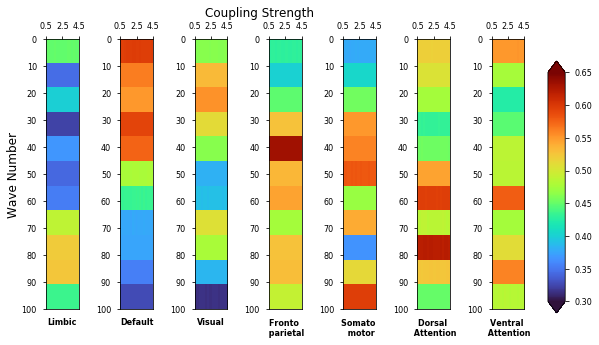

In [4]:
dynamic_range = [0.30, 0.65]
k_ticks = 11
k_labels = np.linspace(0, 100, 11).astype(int)
a_ticks = 3
a_labels = np.linspace(0.5, 4.5, 3)

with plt.style.context("seaborn-paper"):
    corr_fig, corr_ax = plt.subplots(1,7, figsize = (8,5))
    for i, ax in enumerate(corr_fig.axes):
        im = ax.imshow(np.transpose(params_bestr[:,:,i]), vmin = 0, vmax = 1, cmap = turbo, aspect = 'auto')
        ax.yaxis.set_major_locator(plt.LinearLocator(numticks = k_ticks))
        ax.xaxis.tick_top()
        ax.set_yticklabels(k_labels)
        ax.xaxis.set_major_locator(plt.LinearLocator(numticks = a_ticks))
        ax.set_xticklabels(a_labels)
        im.set_clim(dynamic_range)
        if i < 3:
            ax.set_title(fc_names[i], y=-0.08, fontsize=8, weight="bold")
        else:
            ax.set_title(fc_names[i], y=-0.12, fontsize=8, weight="bold")
            
    plt.suptitle('Coupling Strength', fontsize = 12, y = 1)
    cbar_ax = corr_fig.add_axes([1, 0.15, 0.03, 0.7])
    cb = corr_fig.colorbar(im, cax=cbar_ax, extend="both")
    corr_fig.add_subplot(1, 1, 1, frameon=False)
    plt.tick_params(labelcolor="none", top="off", bottom="off", left="off", right="off")
    plt.grid(False)
    plt.ylabel('Wave Number', fontsize = 12)
    
    plt.tight_layout()
    plt.savefig('../figures/fig5/param_bestr.png', dpi = 300, bbox_inches = 'tight')

Note - global coupling doesn't affect the best performing eigenmode but may change which eigenmode is the best performing eigenmode as well as the other eigenmodes.

Split the wave number parameter into oscillatory frequency and signal transmission velocity since wave number $k$ is defined as $k = \frac{2 \pi f}{\nu}$. Then perform the same exploratory exercise as above:

Computing for Limbic network
Computing for Default network
Computing for Visual network
Computing for Frontoparietal network
Computing for Somatomotor network
Computing for Dorsal_Attention network
Computing for Ventral_Attention network


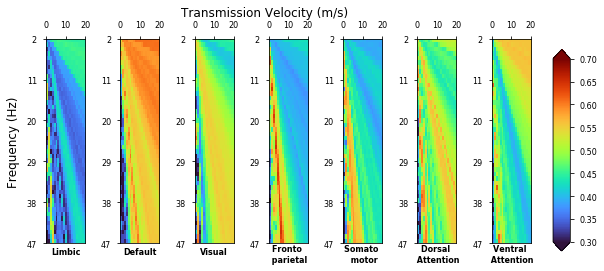

In [5]:
# define parameter ranges:
freq_vec = np.linspace(2, 47, 46)
nu_vec = np.linspace(1, 20, 21)

# define plotting visuals
dynamic_range = [0.3, 0.7]
f_ticks = 6
f_labels = np.linspace(2, 47, 6).astype(int)
nu_ticks = 3
nu_labels = np.linspace(0.5, 20, 3).astype(int)

#pre-allocate array for results
k_bestr = np.zeros((len(freq_vec), len(nu_vec), num_fc))

# compute spearman Rs:
for i in np.arange(0, num_fc):
    print('Computing for {} network'.format(fc_dk_normalized.index[i]))
    for f_ind in np.arange(0, len(freq_vec)):
        for v_ind in np.arange(0, len(nu_vec)):
            # get eigenmodes of complex laplacian:
            hcp_brain.decompose_complex_laplacian(alpha = default_alpha, k = None, f = freq_vec[f_ind], speed = nu_vec[v_ind])
            # compute spearman correlation
            spearman_eig = eigenmode.get_correlation_df(
                hcp_brain.norm_eigenmodes, fc_dk_normalized.iloc[[i]], method = 'spearman'
            )
            k_bestr[f_ind, v_ind, i] = np.max(spearman_eig.values)
            
# Plot as above:
with plt.style.context("seaborn-paper"):
    k_fig, k_ax = plt.subplots(1,7, figsize = (8,4))
    for i, ax in enumerate(k_fig.axes):
        im = ax.imshow(k_bestr[:,:,i], vmin = 0, vmax = 1, cmap = turbo, aspect = 'auto')
        ax.yaxis.set_major_locator(plt.LinearLocator(numticks = f_ticks))
        ax.xaxis.tick_top()
        ax.set_yticklabels(f_labels)
        ax.xaxis.set_major_locator(plt.LinearLocator(numticks = nu_ticks))
        ax.set_xticklabels(nu_labels)
        im.set_clim(dynamic_range)
        if i < 3:
            ax.set_title(fc_names[i], y=-0.08, fontsize=8, weight="bold")
        else:
            ax.set_title(fc_names[i], y=-0.12, fontsize=8, weight="bold")
            
    plt.suptitle('Transmission Velocity (m/s)', fontsize = 12, y = 1)
    cbar_ax = k_fig.add_axes([1, 0.15, 0.03, 0.7])
    cb = k_fig.colorbar(im, cax=cbar_ax, extend="both")
    k_fig.add_subplot(1, 1, 1, frameon=False)
    plt.tick_params(labelcolor="none", top="off", bottom="off", left="off", right="off")
    plt.grid(False)
    plt.ylabel('Frequency (Hz)', fontsize = 12)
    
    plt.tight_layout()
    plt.savefig('../figures/fig5/k_bestr.png', dpi = 300, bbox_inches = 'tight')